# Introduction to Data Science

## Statistical Inference

In [1]:
# This is necessary if the tar file has not been previously extracted
import tarfile
with tarfile.open('../../datasets/ebay_boys_girls_shirts.tar.gz', "r:gz") as tar:
    tar.extractall('../../datasets/')

In [2]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

In [3]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    folder = '../../datasets/ebay_boys_girls_shirts/'
    x_boys_train = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

In [4]:
folder = '../../datasets/ebay_boys_girls_shirts/'
boys_sample = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n = 100, seed = 1976)
girls_sample = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n = 100, seed = 1976)

In [5]:
boys_sample.shape

(100, 100, 100, 3)

In [6]:
boys_red = boys_sample[:, :, :, 0].mean(axis = (1, 2))
girls_red = girls_sample[:, :, :, 0].mean(axis = (1, 2))

In [7]:
print(boys_red.mean())
print(girls_red.mean())

157.291825
169.037971


In [8]:
from scipy.stats import ttest_ind

In [9]:
ttest_ind(boys_red, girls_red)

Ttest_indResult(statistic=-1.734683705624452, pvalue=0.084353029884786934)

# First, without the formulas

* Motivation

* The Null Distribution

* P-Value

## Motivation

You think, you believe, you hypothesize, that girls shirts images on ebay will be more "red" than boys shirts.

No one ever gave this a thought. No one has reason to expect girls shirts to be "redder". You need to prove it.

Let's say operationally this means a higher level of the red pixel channel, as measured on a 0-255 scale.

You manually sample 30 boys shirts images, and 30 girls images, for image you record the average red pixel value:

In [56]:
folder = '../../datasets/ebay_boys_girls_shirts/'

# the function get_images_matrix was previously defined
boys_sample = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n = 30, seed = 1976)
girls_sample = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n = 30, seed = 1976)

boys_red = boys_sample[:, :, :, 0].mean(axis = (1, 2))
girls_red = girls_sample[:, :, :, 0].mean(axis = (1, 2))

print(boys_red)
print(girls_red)

[ 206.6873  142.7774  200.6847  221.994   176.6412   50.482   160.1463
  121.4216  216.085   204.611   247.2997  212.7464  181.6307  120.2983
  120.2855  124.0262  143.3672  126.1494  136.2608  206.1238  195.1573
  175.9014  231.2295  139.2548  151.9433  135.7845  126.2482  203.357
  171.1346  112.8006]
[  38.0918  179.1983  216.0274  224.2845  129.7958  113.9223  114.0991
  250.1969  241.1478  202.9924  214.3335  227.6585  114.9457  163.1921
  225.0518  122.4144  205.8669  234.0529  235.664   185.3179  136.0612
  222.4238   85.9831  235.6591  236.9943  185.8129  151.6073  237.1426
  193.9891  117.7532]


## Motivation

Looking at the values themselves doesn't tell you a lot, you'd probably look at the means:

In [57]:
print(f'Boys shirts mean red value: {boys_red.mean():.2f}')
print(f'Girls shirts mean red value: {girls_red.mean():.2f}')
print(f'Means difference: {girls_red.mean() - boys_red.mean(): .2f}')

Boys shirts mean red value: 165.42
Girls shirts mean red value: 181.39
Means difference:  15.97


It looks as you expected, girls average red pixel is higher by about 16 points, but if you do it again, results would be different, wouldn't they?

In [58]:
boys_sample2 = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n = 30, seed = 1979)
girls_sample2 = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n = 30, seed = 1979)

boys_red2 = boys_sample2[:, :, :, 0].mean(axis = (1, 2))
girls_red2 = girls_sample2[:, :, :, 0].mean(axis = (1, 2))

print(f'Boys shirts mean red value: {boys_red2.mean():.2f}')
print(f'Girls shirts mean red value: {girls_red2.mean():.2f}')
print(f'Means difference: {girls_red2.mean() - boys_red2.mean(): .2f}')

Boys shirts mean red value: 163.45
Girls shirts mean red value: 176.27
Means difference:  12.82


Assume sampling is expensive. You have the capacity for 60 shirts of images.

How will you know, that the difference you're seeing is of significance? That it will "stick"? That what everyone is thinking, the null hypothesis, should be rejected, and your alternative hypothesis is more likely?

## The Null Distribution

Under the null hypothesis, girls and boys shirts come from the same homogenous population.

**For the sake of illustration**, assume this population is at the palm of your hand.

We'll just take all 20K shirts images in our training dataset:

In [13]:
boys_all = get_images_matrix(folder + 'boys_train.csv', folder + 'boys')
girls_all = get_images_matrix(folder + 'girls_train.csv', folder + 'girls')

boys_red_all = boys_all[:, :, :, 0].mean(axis = (1, 2))
girls_red_all = girls_all[:, :, :, 0].mean(axis = (1, 2))
population = np.concatenate([boys_red_all, girls_red_all])

print(population.shape)

(20000,)


## The Null Distribution

We can sample two random samples of so-called "boys" and so-called "girls" to prove to ourselves that the difference between their means should be about zero:

In [14]:
boys_red_null = np.random.choice(population, 30)
girls_red_null = np.random.choice(population, 30)
print(f'Means difference: {girls_red_null.mean() - boys_red_null.mean(): .2f}')

Means difference: -8.35


We got a mean difference which is different than zero, *by random*. And again:

In [15]:
boys_red_null = np.random.choice(population, 30)
girls_red_null = np.random.choice(population, 30)
print(f'Means difference: {girls_red_null.mean() - boys_red_null.mean(): .2f}')

boys_red_null = np.random.choice(population, 30)
girls_red_null = np.random.choice(population, 30)
print(f'Means difference: {girls_red_null.mean() - boys_red_null.mean(): .2f}')

Means difference:  18.01
Means difference:  11.64


## The Null Dsitribution

We want to know how is *our* original mean difference of about 16 points is in comparison to these *null* mean differences between groups coming from the same population. So we'll make a lot of the them and look at their distribution, the Null Distribution of the means difference:

In [16]:
def sample_null_mean_diff(n = 30):
    boys_red_null = np.random.choice(population, n)
    girls_red_null = np.random.choice(population, n)
    return girls_red_null.mean() - boys_red_null.mean()
null_mean_diffs = np.array([sample_null_mean_diff() for i in range(10000)])

print(f'Max null mean diff: {max(null_mean_diffs): .2f}')
print(f'Min null mean diff: {min(null_mean_diffs): .2f}')

Max null mean diff:  48.97
Min null mean diff: -49.81


We can see that the max null mean differences is actually much higher than our original 16 points. So at random, when there is *no difference*, you can get mean differences of over 30 or 40!

Let's look at the Null Distirbution histogram:

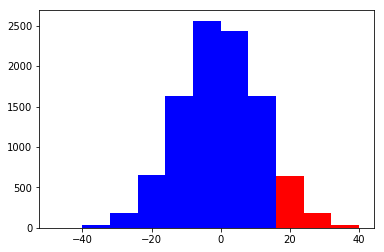

In [17]:
fig, ax = plt.subplots()

N, bins, patches = ax.hist(null_mean_diffs, bins=np.arange(-48, 48, 8))
for i in range(0, 8):
    patches[i].set_facecolor('blue')
for i in range(8, len(patches)):
    patches[i].set_facecolor('red')

plt.show()

It seems like our original value of 16 points difference is not that extreme. There's a measure for that:

## P-Value

How extreme is our original 16 points result?

What is the probability under the Null Distribution, where there is no difference between "boys" and "girls", of getting 16 or higher?

In [18]:
one_sided_p_value = np.mean(null_mean_diffs > 16)
print(f'P(mean_diff >= 16 | H0) = {one_sided_p_value: .2f}')

P(mean_diff >= 16 | H0) =  0.09


It looks like the chance of getting a difference of 16 points or higher, when there is no difference, is ~9%. Does that convince you that there actually is a difference, that indeed the boys and girls samples came from two different, separate, distributions?

It is a standard in both academia and industry to not by persuaded by a p-value larger than 5%.

## P-Value

If the original alternative hypothesis were "Girls shirts images red level is *different* than Boys'", the p-value should have been two sided.

Because the probability of getting our original value or "more extreme" would have meant "more extreme in absolute value":

In [19]:
two_sided_p_value = np.mean(np.abs(null_mean_diffs) > 16)
print(f'P(|mean_diff| >= 16 | H0) = {two_sided_p_value: .2f}')

P(|mean_diff| >= 16 | H0) =  0.17


17-18% chance of observing a result like 16 points or more extreme, at random, when there is no difference. 16 points doesn't look convincing.

But in real life we only have that one hard-earned sample. We don't have the population. And from here, the rest is mathematical approximation for getting that p-value and other measures, with what we have.

# Now, with the formulas

* The Normal Distribution: Why?

* The Normal Distribution: Refresher

* Central Limit Theorem

* Z-Test

* From Z-Test to T-test

* One-Sample, Two-Samples T-Test

* Confidence Intervals

* Power

## The Normal Distribution

Since we have our "population" of red pixel levels in boys and girls shirts images, we might as well see how it is distirbuted:

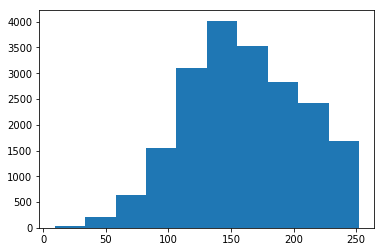

In [20]:
plt.hist(population)
plt.show()

There is nothing "normal" about this distribution, it isn't bell-shaped. So why are we so obsessed with the Normal Distribution?

First, recall that we didn't care so much about the distribution of red pixel levels, but the distribution of differences between the means of two random groups under the null hypothesis. And this distribution, amazingly, did have a bell shape:

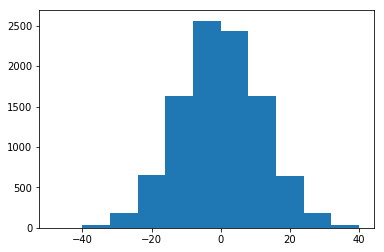

In [21]:
plt.hist(null_mean_diffs, bins = np.arange(-48, 48, 8))
plt.show()

Second, recall that our final metric (for now) is the p-value. We need a way of computing this p-value without having the population at the palm of our hand. The Normal Distribution lets us compute any probability p with just two numbers ($\mu$ and $\sigma$), so it would be very convenient to have a normal Null Distribution.

## The Normal Distribution: Refresher

With Discrete RVs we usually talk about "Probability Mass Function" (PMF).

With Continuous RVs we talk about "Probability Density Function" (PDF).

If $X \sim N(\mu, \sigma^2)$ its desnsity function is defined as:

$f(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{\frac{- ( {x - \mu } )^2 }{2\sigma^2}}$

And if $\mu = 0$ and $\sigma = 1$ (a.k.a the Standard Normal Distribution $N(0, 1)$) it looks like:

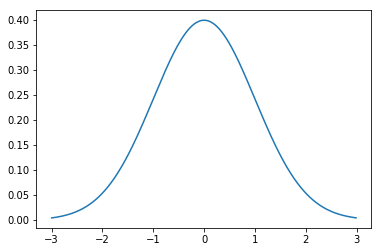

In [22]:
import scipy.stats as stats

x = np.arange(-3, 3, 0.01)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.show()

The density function $f(x)$ is a positive real function, the area under which is 1.

But notice that its values are NOT probabilities (Run `stats.norm.pdf(x, 0, 0.1)` and see!). Probabilities are *areas*.

And to get those areas (probabilities) we *integrate*:

$P(X \leq a) = \int_{-\infty}^a f(x) \;dx.$

That last function is known as the Cumulative Distribution Function (CDF), $F_X(a)$.

It is used so much in the Standard Normal Distribution that we denote it $\phi(a)$:

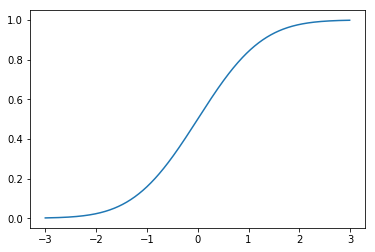

In [23]:
plt.plot(x, stats.norm.cdf(x, 0, 1))
plt.show()

Note that you could convert any $N(\mu, \sigma)$ distribution into a $N(0, 1)$ distribution, by *standardizing*, getting the "Z variable":

$Z = \frac{X - \mu}{\sigma} \sim N(0, 1)$

### $\mu$ and $\sigma$

The pair of parameters $\mu$ and $\sigma$ are enough to define a Normal distribution.

The Normal distribution was parametrized in such a way that $\mu$ and $\sigma$ tell us the most important measures about this distribution, its expectation is $\mu$ and standard deviation is $\sigma$.

Morever, once a RV distributes Normal, we know roughly what percentage of the distribution is within one, two, three standard deviations off the mean, e.g. ~95% of the distribution is within 2 $\sigma$s off the mean:

<img src = 'images/normal_dist.png' width = "50%" height = "50%">

For example, in our Null Distribution of mean differences, which had a bell shape to it:

In [24]:
mu = np.mean(null_mean_diffs)
sigma = np.std(null_mean_diffs)
print(f'Mean of mean differences: {mu: .2f}')
print(f'SD of mean differences: {sigma: .2f}')

Mean of mean differences: -0.07
SD of mean differences:  11.86


We could fit the Normal distribution with these parameters over the histogram, and see if the fit is "good":

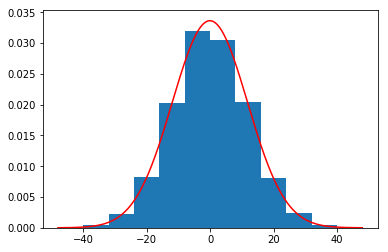

In [25]:
plt.hist(null_mean_diffs, bins = np.arange(-48, 48, 8), density = True)
x = np.arange(-48, 48, 0.01)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red')
plt.show()

The fit looks "good", and so we could say that 95% of the distribution is within 2 standard deviations off the mean:

In [26]:
print(f'({mu - 2 * sigma: .2f}, {mu + 2 * sigma: .2f})')

(-23.78,  23.65)


Our original samples means difference of 16 points is well within these boundaries.

## Central Limit Theorem

The CLT states that for a random sample ${X_1, ..., X_n}$ from a population with mean $E(X) = \mu$ and finite variance $V(X) = \sigma^2$, for large enough sample size $n$:

$\overline{X} \dot{\sim} N(\mu, \frac{\sigma^2}{n})$

Or in oter words:

$\frac{\overline{X} - \mu}{\sigma / \sqrt{n}} \dot{\sim} N(0, 1)$

* $\frac{\sigma}{\sqrt{n}}$ is called the Standard Error (SE) of the mean

* $\frac{\overline{X} - \mu}{\sigma / \sqrt{n}}$ is the Z statistic

That is a bold statement.

### Exponential Distribution Demo

The Exponential Distribution is another well researched continuous distribution. $X \sim Exp(\lambda)$:

$Supp(X) = [0, \infty]$ (also $\lambda > 0$)

$f(X) = \lambda e^{-\lambda x}$

$F_x(k) = P(X \leq k) = 1 - e^{-\lambda x}$

$E(X) = \frac{1}{\lambda}$

$V(X) = \frac{1}{\lambda^2}$

Example: X is the time between two trains from Tel-Aviv to Haifa which come on average every 20 minutes (1/3 hour). So: $X \sim Exp(3)$

How it looks (definitely not normal):

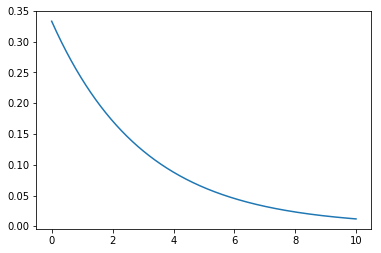

In [28]:
x = np.arange(0, 10, 0.01)
plt.plot(x, stats.expon.pdf(x, scale = 3))
plt.show()

### Exponential Distribution Demo

A demo where $X \sim Exp(3)$, sampling distribution of the mean with $n = 30$:

<img src = "images/clt_exp3_n30.gif">

### Exponential Distribution Demo

A demo where $X \sim Exp(3)$, sampling distribution of the mean with $n = 5$:

<img src = "images/clt_exp3_n5.gif">

## Z-Test

The trains from Tel-Aviv to Haifa come every 20 minutes? (null  hypothesis)

Lately it seems like a lot more. (alternative hypothesis)

I randomly sampled 30 waiting times between two trains, and got an average $\overline{X} = 4/9$ or 26 minutes and 40 seconds.

Under the null hypothesis, the CLT says that: $\overline{X} \dot{\sim} N(\frac{1}{3}, \frac{1/9}{30})$

Or: $\frac{\overline{X} - 1/3}{1/\sqrt{270}} \dot{\sim } N(0, 1)$

We got: $\overline{X} = 4/9$, or $Z = \frac{4/9 - 1/3}{1/\sqrt{270}} = 1.8257$

We can compute a p-value!

In [73]:
one_sided_p_value = 1 - stats.norm.cdf(4/9, 1/3, np.sqrt(1/270))
#or
one_sided_p_value = 1 - stats.norm.cdf(1.8257, 0, 1)

print(f'P(X_bar >= 4/9 | H0) = {one_sided_p_value: .2f}')

P(X_bar >= 4/9 | H0) =  0.03


And this looks pretty extreme (lower that 5%), and we "reject the null hypothesis" and conclude that indeed it seems like the waiting time has increased.

## Back to Girls and Boys Shirts

Let $X$ be the red pixel level of girls shirts images.

Let $Y$ be the red pixel level of boys shirts images.

(We *know* they do not distribute normally, but in a realistic scenario, we don't)

Under $H0$ they both come from the same distribution with $E(X) = E(Y) = \mu$ and $V(X) = V(Y) = \sigma^2$, and let's assume $\sigma^2$ is finite.

Sample size was $n = 30$ for both independent samples.

So under $H0$, according to CLT, the sampling distribution for both samples means is Normal: $\overline{X} \sim N(\mu, \frac{\sigma^2}{n})$, $\overline{Y} \sim N(\mu, \frac{\sigma^2}{n})$

We were interested in the distribution of the means differences, which we now know should be approximately Normal:

$\overline{X} - \overline{Y} \sim N(0, \frac{\sigma^2}{n} + \frac{\sigma^2}{n})$ (make sure you understand why!)

In other words:

$\frac{\overline{X} - \overline{Y}}{\sqrt{\frac{2 \sigma^2}{n}}} \sim N(0, 1)$

Only one thing is missing: we do not know what $\sigma$ is (Do we know what $\mu$ is? Why is that not a problem?)

### Girls and Boys Shirts - Z-Test

Let's assume for now we estimate it from the population: $\sigma$ = `np.std(population) = 45.8`.

So: $\overline{X} - \overline{Y} \sim N(0, 11.84^2)$

Or: $\frac{\overline{X} - \overline{Y}}{11.84} \sim N(0, 1)$

And we got: $\overline{X} - \overline{Y} = 16$, or $Z = \frac{16}{11.84} = 1.35$

And we can perform a Z-Test and compute the p-value:

In [48]:
one_sided_p_value = 1 - stats.norm.cdf(16, 0, 11.84)
#or
one_sided_p_value = 1 - stats.norm.cdf(1.35, 0, 1)

print(f'P(mean_diff >= 16 | H0) = {one_sided_p_value: .2f}')

P(mean_diff >= 16 | H0) =  0.09


Which is similar to the result we got using our "known population".

## From Z-Test to T-Test

But $\sigma$ isn't known!

It turns out that in general, for a Standard Normal RV $\frac{\overline{X} - \mu}{\sigma / \sqrt{n}}$, once $\sigma$ is unknown and is replaced by the unbiased estimator $S = \sqrt{\frac{1}{n - 1}\sum{(X_i - \overline{X})^2}}$:

$\frac{\overline{X} - \mu}{S / \sqrt{n}} \sim t_{n - 1}$

This statistic distributes "$t$ with $n - 1$ degrees of freedoms (df)", hence called the T statistic.

Notice that last result does not depend on $n$, you need large $n$ for using CLT in the first place (unless you assume the original distribution to be Normal), and for higher power (see later).

The t distribution typically has "longer tails" than the Standard Normal distribution for small $n$, reflecting the added uncertainty once $\sigma$ isn't known but estimated by $S$.

But for $n \geq 120$ it is similar to the Standard Normal:

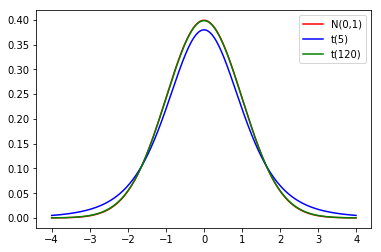

In [85]:
x = np.arange(-4, 4, 0.01)
plt.plot(x, stats.norm.pdf(x, 0, 1), color = 'red')
plt.plot(x, stats.t.pdf(x, 5), color = 'blue')
plt.plot(x, stats.t.pdf(x, 120), color = 'green')
plt.gca().legend(('N(0,1)','t(5)', 't(120)'))
plt.show()

## One Sample T-Test

Again: Under $H0$, with a large sample $n$, according to CLT: $\frac{\overline{X} - \mu}{\sigma / \sqrt{n}} \sim N(0, 1)$ 

Now the $\sigma$ is unknown. $\mu$ is known under the null hypothesis, often $H0 : \mu = 0$

We replace $\sigma$ by its estimator: $S = \sqrt{\frac{1}{n_x - 1}\sum{(X_i - \overline{X})^2}}$

We get:

$\frac{\overline{X} - \mu_{H0}}{\sqrt{\frac{S^2}{n}}} \sim t_{n - 1}$

And you can perform a t-test using e.g. `stats.ttest_1samp(x, 0)`.

## Two Independent Samples T-Test

In our case: Under $H0$, with a large sample as $n = 30$, according to CLT: $\frac{\overline{X} - \overline{Y}}{\sqrt{\frac{2 \sigma^2}{n}}} \sim N(0, 1)$ 

In general: $X$ and $Y$ need not come from the same distribution, the difference in means need not be 0, their variances need not be equal and their sample sizes need not be equal: 

$\frac{(\overline{X} - \overline{Y}) - (\mu_x - \mu_y)}{\sqrt{\frac{\sigma_x^2}{n_x} +\frac{\sigma_y^2}{n_y}}} \sim N(0, 1)$

Now the $\sigma_x$ and $\sigma_y$ are unknown. $\mu_x$ and $\mu_y$ are also unknown but often under $H0: \mu_x - \mu_y = 0$

We replace $\sigma_x$ by its estimator: $S_x = \sqrt{\frac{1}{n_x - 1}\sum{(X_i - \overline{X})^2}}$ and the same for $\sigma_y$.

We get:

$\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_x^2}{n_x} +\frac{S_y^2}{n_y}}} \sim t_{?}$

### Equal Variances Assumed

Once equal variances are assumed we use the "pooled" estimated variance:

$S^2_p = \frac{(n_x - 1)S^2_x + (n_y - 1)S^2_y}{n_x + n_y - 2}$

And the distribution is t with $n_x + n_y - 2$ degrees of freedom:

$\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} \sim t_{n_x+n_y -2}$

### Unequal Variances Assumed

We keep the SE estimator of $\sqrt{\frac{S_x^2}{n_x} +\frac{S_y^2}{n_y}}$:

$\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_x^2}{n_x} +\frac{S_y^2}{n_y}}} \sim t_{df'}$

Where: $df' ={\frac {\left({\frac {s_{1}^{2}}{n_{1}}}+{\frac {s_{2}^{2}}{n_{2}}}\right)^{2}}{{\frac {\left(s_{1}^{2}/n_{1}\right)^{2}}{n_{1}-1}}+{\frac {\left(s_{2}^{2}/n_{2}\right)^{2}}{n_{2}-1}}}}$



### Girls and Boys Shirts - T-Test

Recall the null hypothesis: $H0: \mu_x = \mu_y$

We will use the equal variances assumed version.

First manually:

In [83]:
S2_x = np.var(girls_red, ddof = 1) # for getting the "n - 1" unbiased estimator of sigma
S2_y = np.var(boys_red, ddof = 1)
n_x = n_y = 30
S2_p = ((n_x - 1)*S2_x + (n_y - 1)*S2_y) / (n_x + n_y - 2)

t_statistic = (np.mean(girls_red) - np.mean(boys_red))/np.sqrt(S2_p/n_x + S2_p/n_y)
print(f'T statistic: {t_statistic: .4f}')

one_sided_p_value = 1 - stats.t.cdf(t_statistic, n_x + n_y - 2)

print(f'P(mean_diff >= 16 | H0) = {one_sided_p_value: .2f}')

T statistic:  1.2191
P(mean_diff >= 16 | H0) =  0.11


Now with Python's built-in function:

In [75]:
stats.ttest_ind(girls_red, boys_red)

Ttest_indResult(statistic=1.2191309822847303, pvalue=0.22772950529997951)

The T statistic is the same, but the p-value is twice the result we got because the Python function always computes the two-sided p-value.

Anyway, p-value of 11% isn't convincing and we do not reject the null hypothesis.

Notice the T-test p-value of 11% is greater than the Z-test p-value of 9%, which makes sense:

Gave up the known variance assumption, added uncertainty (the variance is now in itself a RV), got the t distribution with "heavier" tails, need more extreme values to impress.

## Confidence Intervals (CI)

One (of a few) problem with p-value: it is not informative.

With large enough sample size any result can become "significant" (why?).

Statistical significance is not scientific significance.

Often we would prefer reporting what the actual mean $\mu$ (or means difference $\mu_x - \mu_y$) was, to show it was "interesting". 

But since our sample mean $\overline{X}$ (or sample means difference $\overline{X} - \overline{Y}$) is most probably WRONG, it comes with uncertainty, we report a Confidence Interval:

"$\mu$ is within [10, 20] with 95% level of confidence"

### Building the CI: Z-Test

In general: for a random sample $X$ from distribution with unknown parameter $\theta$, $[LB(X), UB(X)]$ is a $100(1-\alpha)\%$ CI for $\theta$ if $P(LB(X) < \theta < UB(X)) = 1 - \alpha$

Usually: $\alpha = 0.05$ and we would build a *symmetric* CI around some $\hat{X}$ estimator of $\theta$, like $\overline{X}$

For the Z-test:

$P(Z_{2.5} < \frac{\overline{X} - \mu}{\sigma/\sqrt{n}} < Z_{97.5}) = P(\overline{X} + Z_{2.5}\frac{\sigma}{\sqrt{n}} < \mu < \overline{X} + Z_{97.5}\frac{\sigma}{\sqrt{n}}) = 0.95$ where $Z_q$ is the $q$th percentile of the $N(0, 1)$ distribution

$\implies [\overline{X} + Z_{2.5}\frac{\sigma}{\sqrt{n}}, \overline{X} + Z_{97.5}\frac{\sigma}{\sqrt{n}}]$ or $\overline{X} \pm 1.96\frac{\sigma}{\sqrt{n}}$ is a 95% CI for $\mu$

### CI for Waiting Time for Train

Recall: Under $H0$ $X \sim Exp(3)$ so: $\sigma = \frac{1}{3}$

We got: $\overline{X} = \frac{4}{9}; \space n = 30;$

95% CI for $\mu$:

In [96]:
LB = 4/9 - stats.norm.ppf(0.975) * (1/3)/np.sqrt(30)
UB = 4/9 + stats.norm.ppf(0.975) * (1/3)/np.sqrt(30)
print(f'[{LB: .3f}, {UB: .3f}]')

[ 0.325,  0.564]


Most common misconception of CI: "The probability that $\mu$ is within [0.33, 0.56] is 95%"
    
No. $\mu$ is either within the CI or not, $\mu$ is a parameter, not a RV!

But what *does* it mean?

### CI for Mean Demo

A demo where $X \sim Exp(3)$, sampling distribution of the mean with $n = 30$:

<img src = "images/ci_exp3_n30.gif">

### CI for Mean Demo

A demo where $X \sim Exp(3)$, sampling distribution of the mean with $n = 5$:

<img src = "images/ci_exp3_n5.gif">

### Building the CI: T-Test

For One-Sample T-Test:

$[\overline{X} + t_{n-1;2.5}\frac{S}{\sqrt{n}}, \overline{X} + t_{n-1;97.5}\frac{S}{\sqrt{n}}]$ or $\overline{X} \pm t_{n-1,97.5}\frac{S}{\sqrt{n}}$ is a 95% CI for $\mu$

For Two-Samples T-Test, equal variances assumed:

$[(\overline{X} - \overline{Y}) + t_{n_x+n_y-2;2.5}\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}, (\overline{X} - \overline{Y}) + t_{n_x+n_y-2;97.5}\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}]$ or $(\overline{X} - \overline{Y}) \pm t_{n_x+n_y-2,97.5}\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}$ is a 95% CI for $\mu$

### Girls and Boys Shirts - Confidence Interval for Means Difference

Recall we got: $\overline{X} - \overline{Y} = 16; \space n_x = 30; \space n_y = 30; S^2_p = 2574$

95% CI for $\mu_x - \mu_y$:

In [95]:
LB = (np.mean(girls_red) - np.mean(boys_red)) - stats.t.ppf(0.975, n_x + n_y - 2) * np.sqrt(S2_p/n_x + S2_p/n_y)
UB = (np.mean(girls_red) - np.mean(boys_red)) + stats.t.ppf(0.975, n_x + n_y - 2) * np.sqrt(S2_p/n_x + S2_p/n_y)
print(f'[{LB: .1f}, {UB: .1f}]')

[-10.3,  42.2]


## Power